# Analyzing ratings of Google Play Store applications 
## Supplementary notebook

This notebook is supplement to the paper ["Analyzing ratings of Google Play Store applications"](../paper/paper.pdf). All relevant preprocessing, analysis and visualization steps can be found here. It goes into detail about why and how certain decisions were made.

## Data exploration and prepocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.neurips2021(usetex=False))
plt.rcParams["font.family"] = "Times New Roman"

pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('../data/googleplaystore.csv')

First, we have a look at the data and throw some summary statistics:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
# Get all distinct categories

data['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [5]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We see that some columns should be of numerical type, but are not, probably because of missing/corrupted entries. Now we are going to fix that.

In [6]:
data.loc[data['Installs']=='Free']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [7]:
# data cleansing

ind = data.loc[data['Installs']=='Free'].index[0]
corrupted_row = data.iloc[[ind]]

# this row seems to be shifted to the left because of a missing value 
corrupted_row = corrupted_row.shift(periods=1,axis="columns")
corrupted_row['App'] = corrupted_row['Category']

# assign the most likely category based on Google search
corrupted_row['Category'] = "LIFESTYLE"

data.iloc[[ind]] = corrupted_row
data.iloc[[ind]]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,LIFESTYLE,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up


Further, the approximate number installs is given as a string, but we can convert them to integers.

In [8]:
# Convert installs to integer
data['Installs'] = data['Installs'].apply(lambda x: re.search('\d+',x.replace(',',''))[0])

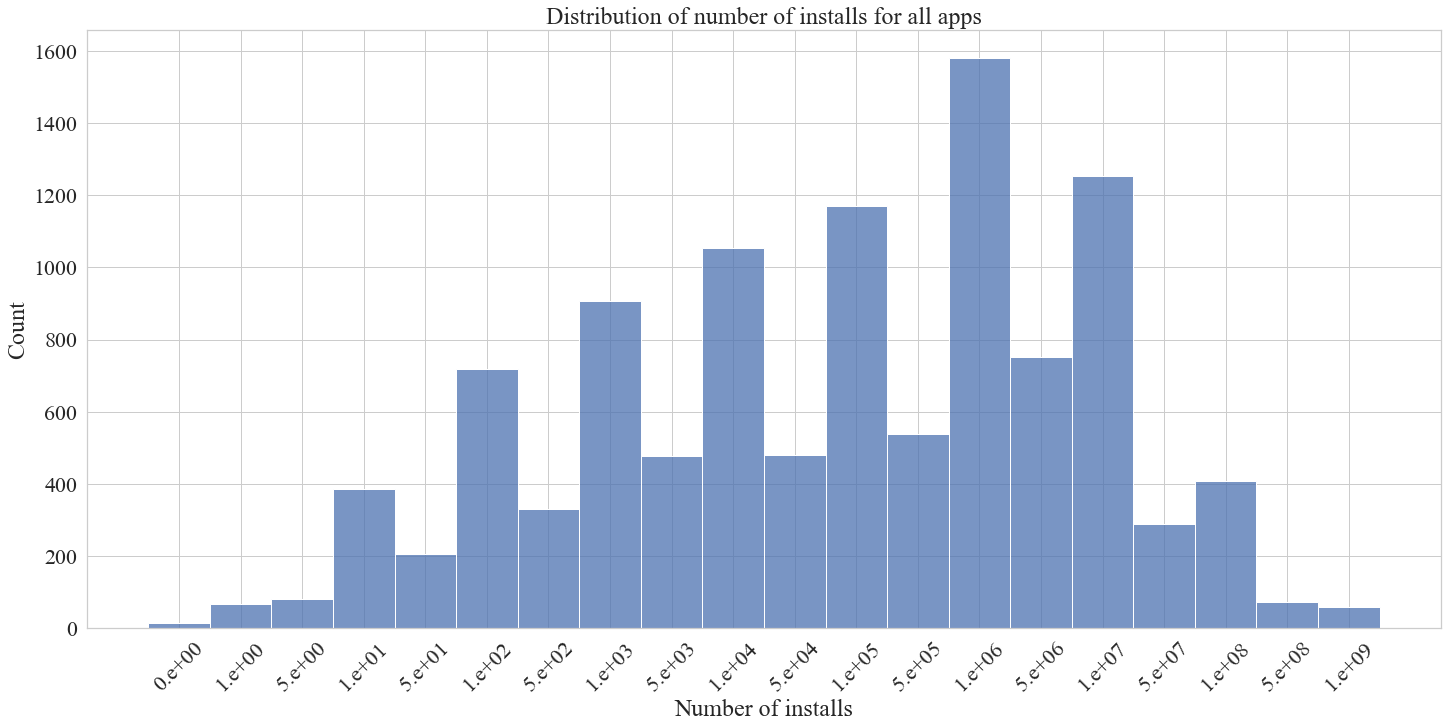

In [9]:
plt.rcParams['figure.figsize'] = 20,10
sns.set(font_scale=2, font="Times New Roman", style="whitegrid")

# Get number of installs
installs_formatted = pd.to_numeric(data['Installs']).sort_values().apply(lambda x: np.format_float_scientific(x))

sns.histplot(installs_formatted.astype(str), bins=20)
plt.title('Distribution of number of installs for all apps')
plt.xlabel('Number of installs')
plt.xticks(rotation=45)
plt.show()

The periodic behaviour of the counts tells us that, due to the rounding, the approximations are pretty rough. Since the gaps between the bins get exponentially larger, it is better to assume that this feature is categorical.

In [10]:
# convert appropriate columns to integer
data['Installs'] = pd.to_numeric(data['Installs'])
data['Reviews'] = pd.to_numeric(data['Reviews'])
data['Rating'] = pd.to_numeric(data['Rating'])
data['Price'] = data['Price'].apply(lambda x: re.search('\d+',x.replace('.',''))[0])
data['Price'] = pd.to_numeric(data['Price'])

Now we look at the rating distribution. We set a small cutoff to the number of Reviews in order to remove some of the noise. We then include the missing values to get a better picture of the dataset.

Text(0.5, 1.0, 'Rating distribution of apps')

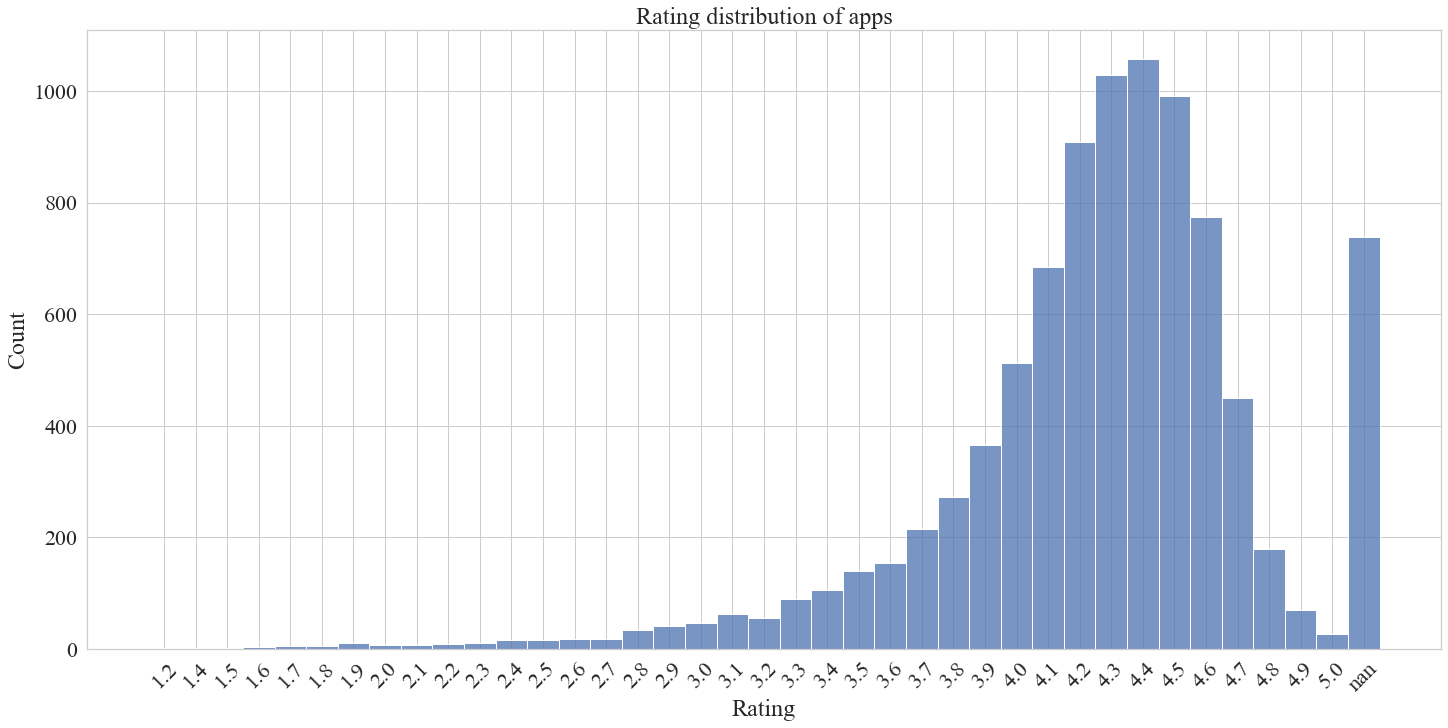

In [11]:
sns.histplot(pd.to_numeric(data.query('Reviews > 20 | Reviews < 1')['Rating']).sort_values().astype(str), bins=40)
plt.xticks(rotation=45)
plt.title('Rating distribution of apps')

This plot tells us that the majority of the apps receive above average rating, which means that we probably have to redefine the notion of a "good-rated" and "bad-rated" app. We also see that there is a considerable amount of NA values, which shall be removed for further analyses.

In [12]:
# remove NA values from ratings

ratings_data = data[~data['Rating'].isna()]

We are also interested in the number of free and paid apps, which will be useful in the subsequent analysis.

In [13]:
free_count = ratings_data.query('Type == "Free"').shape[0]
paid_count = ratings_data.query('Type == "Paid"').shape[0]

print(f'Number of free apps: {free_count}')
print(f'Number of paid apps: {paid_count}')

Number of free apps: 8720
Number of paid apps: 647


## Question 1 - Do paid apps receive better ratings?

We start by looking at the rating distributions for free and paid apps:

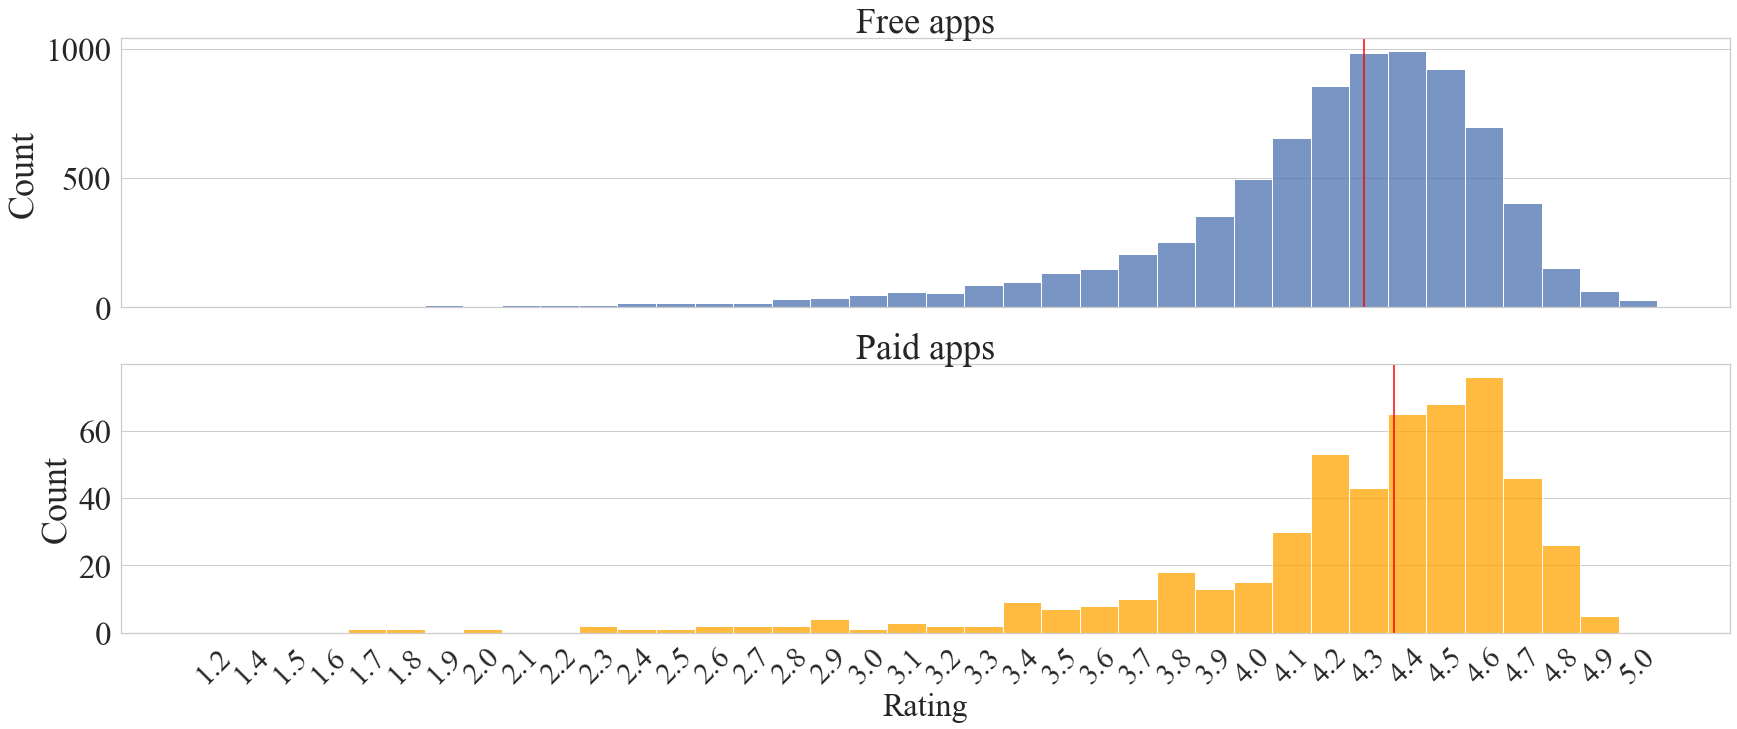

In [14]:
ratings_free = pd.to_numeric(ratings_data.query('Type == "Free" & Reviews > 20')['Rating'])
ratings_paid = pd.to_numeric(ratings_data.query('Type == "Paid" & Reviews > 20')['Rating'])

# 4.18
mean_free = ratings_free.mean()

# 4.26
mean_paid = ratings_paid.mean()

# some values from the [1,5] range are missing, so some minor tweeks are needed to adjust the vertical lines
plt.rcParams['figure.figsize'] = 24,10
sns.set(font_scale=3, font="Times New Roman", style="whitegrid")

fig, axs = plt.subplots(2,1,sharex=True)
sns.histplot(ratings_free.sort_values().astype(str),ax=axs[0])
axs[0].axvline(x=(mean_free-1.2)*10,color='red')
axs[0].title.set_text('Free apps')
axs[0].xaxis.grid(False)

sns.histplot(ratings_paid.sort_values().astype(str),ax=axs[1], color='orange')
axs[1].axvline(x=(mean_paid-1.2)*10,color='red')
axs[1].title.set_text('Paid apps')
axs[1].xaxis.grid(False)

plt.xlabel('Rating', fontsize=32)
plt.xticks(rotation=45, fontsize=30)
plt.savefig('../figures/rating_distr.png',dpi=400)

Suprisingly, the plot shows that both distributions are nearly equal. Next, we are going to use a statistical test to make this observation more precise.

The test we are going to use is called the Kolmogorov-Smirnov test. It is one of the most popular tests used to determine whether two samples are equal. The null hypothesis of the test is that both distributions are the same. Conveniently, it can be used directly from the scipy package.

In [15]:
from scipy import stats
stats.ks_2samp(ratings_free, ratings_paid)

KstestResult(statistic=0.13899239308669797, pvalue=1.2253536185724556e-08)

We can see that the p value is small enough, so we can safely reject the null hypothesis and conclude that both distributions are different.

This result is not suprising, since one would expect that users who buy apps tend to do some prior research, or at least be selective when buying apps. On the other hand, when buying an app, users tend to put higher expectations on them, which could explain why there are a lot of apps with below-average ratings.

## Question 2 - How does the app rating relate to other features?

We can go one step further and ask how the price affects the app rating. We first plot both features by, again, filtering out apps with very low ratings and number of reviews:

In [16]:
data_f = ratings_data.query('Reviews > 20 & Rating > 2.5')

C:\Users\user\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


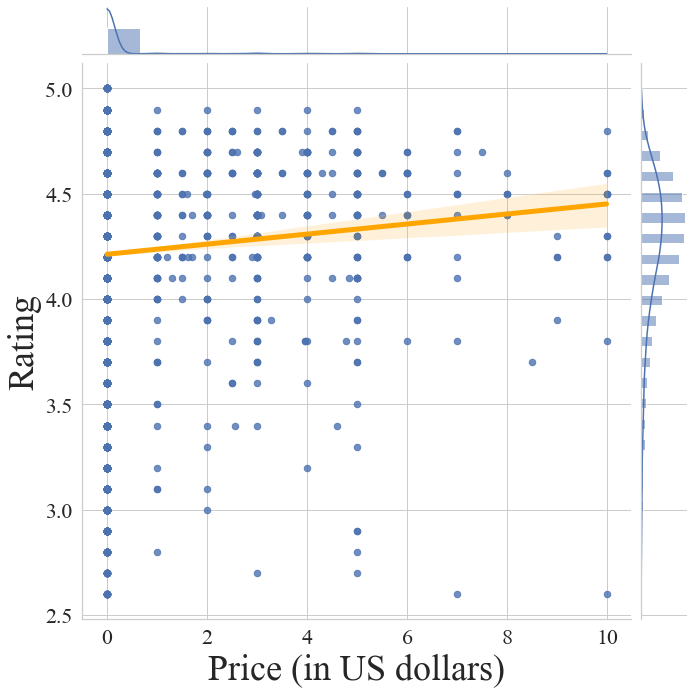

In [39]:
plt.rcParams['figure.figsize'] = 11.7,8.27
sns.set(font_scale=2, font="Times New Roman", style="whitegrid")

data_pr = data_f.query('Price < 1000')
data_pr['Price'] = data_pr['Price']/100
ax = sns.jointplot(x="Price", y="Rating", data=data_pr, kind='reg',joint_kws={'line_kws':{'color':'orange', 'linewidth': 5}}, scatter_kws={'s': 42}, height=10, ratio=10)
ax.ax_joint.set_xlabel('Price (in US dollars)',fontsize=36)
ax.ax_joint.set_ylabel('Rating',fontsize=36)
plt.savefig('../figures/price.png')

From this plot we can see that increasing app price also increases the rating. Alas, simply increasing the price won't guarantee increase in profit, as then the target audience would shrink. We can already see this by observing that there are extremely few apps on the right side of the plot. To see how price affects popularity, we can also compute the number of installs per type:

In [40]:
pr_ins_paid = data_pr.query('Type == "Paid"')['Installs'].sum()
pr_ins_free = data_pr.query('Type == "Free"')['Installs'].sum()
free_ratio = pr_ins_free/free_count
paid_ratio = pr_ins_paid/paid_count

print(f'{free_ratio/paid_ratio:2f}')

173.321777


Nevertheless, a paid app which provides more features than similar free apps is bound to be successful.

## Relating rating to other features

Besides the price, we can also look at other features to see if some trends can be found. Based on the data exploration we have done above, the only suitable candidates which can be manipulated from the development/business team are the size and the last updated date. Further, we can argue that the number of installs is also a feature that can tell us more about the app quality.

The plots below show the relationship between the app rating and these three features.

C:\Users\user\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


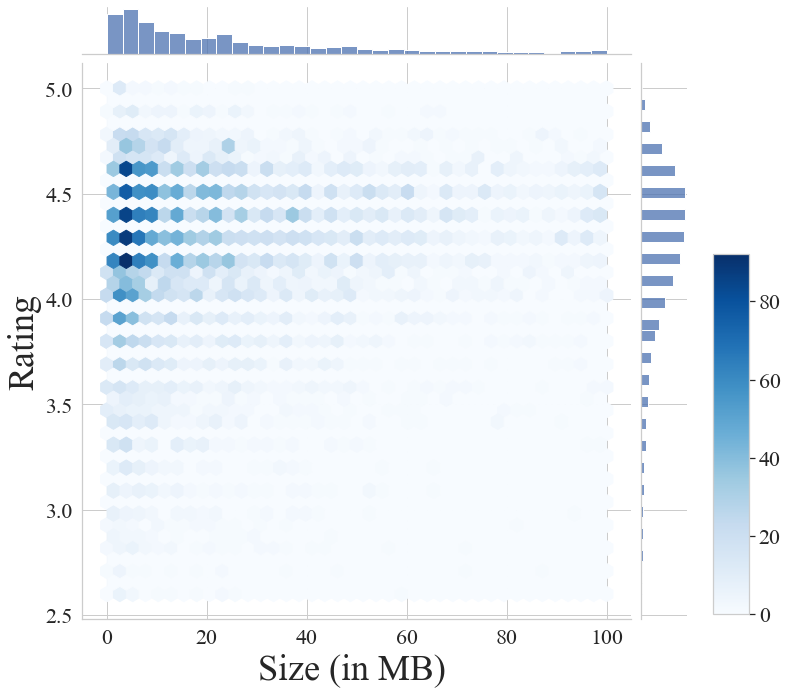

In [54]:
# convert the size to the same unit (and discard varying values) 
def size_to_abs(x):
    if x.endswith('M'):
        return float(x[:-1])
    if x.endswith('k'):
        return float(x[:-1])*10**(-3)
    return np.nan

data_f['Size_abs'] = data_f['Size'].apply(size_to_abs)
ax = sns.jointplot(x="Size_abs", y="Rating", data=data_f, kind='hex',cmap='Blues', height=10, ratio=10)
ax.ax_joint.set_xlabel('Size (in MB) ',fontsize=36)
ax.ax_joint.set_ylabel('Rating',fontsize=36)

cbar_ax = ax.fig.add_axes([1, .12, .05, .5])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.savefig('../figures/size.png',bbox_inches="tight")

C:\Users\user\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


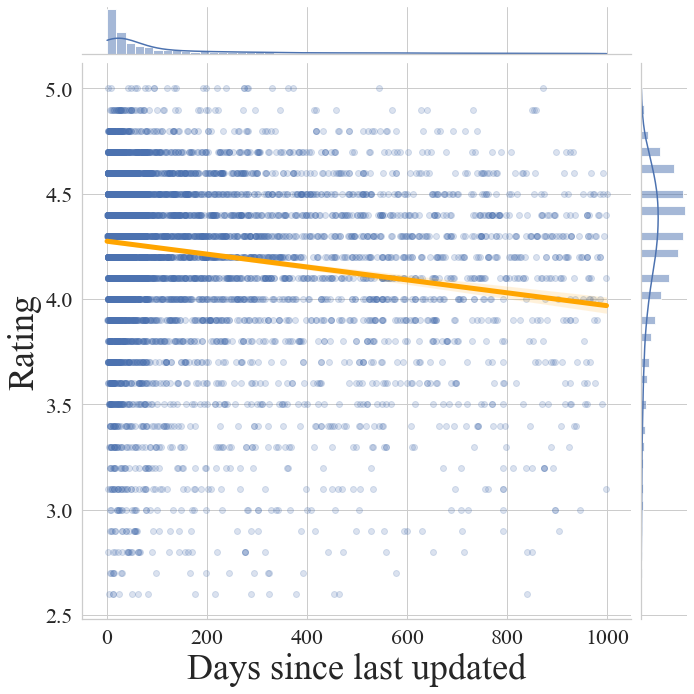

In [42]:
data_f['new'] = pd.to_datetime(data_f['Last Updated'])
data_f['lastupdate'] = (data_f['new'].max() - data_f['new']).dt.days
data_lu = data_f.query('lastupdate < 1000')

ax = sns.jointplot(x="lastupdate", y="Rating", data=data_lu, kind='reg', joint_kws={'line_kws':{'color':'orange', 'linewidth': 5}, 'scatter_kws':dict(alpha=0.2)},height=10,ratio=10)
ax.ax_joint.set_xlabel('Days since last updated',fontsize=36)
ax.ax_joint.set_ylabel('Rating',fontsize=36)
plt.savefig('../figures/updated.png')

C:\Users\user\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


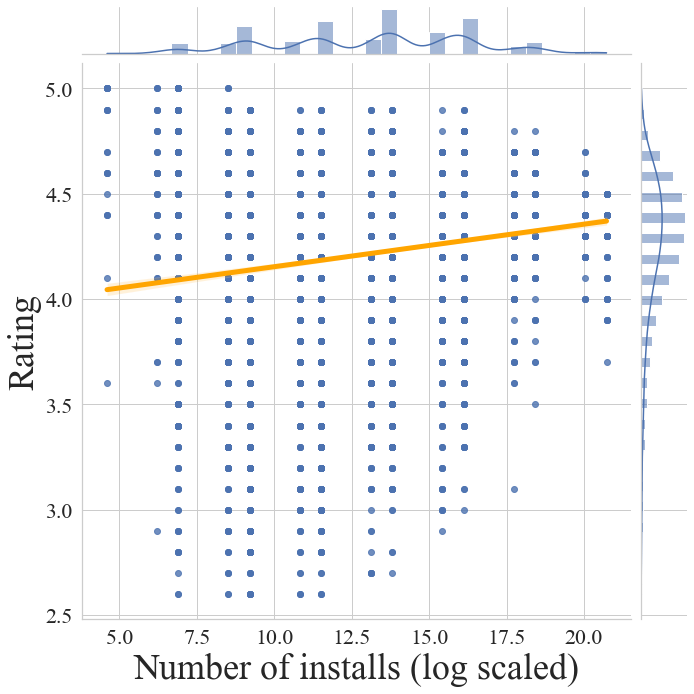

In [55]:
data_f['LogInstalls'] = np.log(data_f['Installs'])
ax = sns.jointplot(x="LogInstalls", y="Rating",data=data_f,kind='reg', joint_kws={'line_kws':{'color':'orange', 'linewidth': 5}}, height=10,ratio=10);
# ax.ax_joint.set_xscale('log')  # set_yscale is a function, not a string
ax.ax_joint.set_xlabel('Number of installs (log scaled)',fontsize=36)
ax.ax_joint.set_ylabel('Rating',fontsize=36)
plt.savefig('../figures/installs.png')